# Разработка прогнозных моделей для отбора животных в поголовье

## 1. Шаг 1. Загрузка и изучение данных

### 1.1 Начнем работу с датасетами

In [1]:
# произведем необходимые импорты
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression

from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score, accuracy_score, 
    confusion_matrix, 
    recall_score, 
    precision_score
)

from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.multiclass import OneVsRestClassifier

In [2]:
# создадим функцию вывода информации о датасете
def dataset_info(dataset):
    display(dataset.info())
    display(dataset.describe())
    display(dataset.head())
    
# создадим функцию расчета доверительного интервала модели    
def interval(n, predictions):
    i = st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions))
    print(f'95% доверительный интервал модели № {n}: {i}')

In [3]:
pd.set_option('display.max_columns', None) # установим опцию по выводу всех колонок датафрейма

# укажем формат отображения больших чисел,
pd.set_option('display.float_format', '{:.2f}'.format) # чтобы не применялась экспоненциальная запись в таблицах

In [4]:
# прочитаем файлы
ferma_main = pd.read_csv('./ferma_main.csv', sep= ';')
ferma_dad = pd.read_csv('./ferma_dad.csv', sep= ';')
cow_buy = pd.read_csv('./cow_buy.csv', sep= ';')

### 1.2 Изучим общую информацию о каждом датафрейме

In [5]:
dataset_info(ferma_main)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   id                                     634 non-null    int64 
 1   Удой, кг                               634 non-null    int64 
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    object
 3   Сырой протеин, г                       634 non-null    int64 
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    object
 5   Порода                                 634 non-null    object
 6   Тип пастбища                           634 non-null    object
 7   порода папы_быка                       634 non-null    object
 8   Жирность,%                             634 non-null    object
 9   Белок,%                                634 non-null    object
 10  Вкус молока                            634 non-null    object
 11  Возраст            

None

,id,"Удой, кг","Сырой протеин, г"
count,634.00,634.00,634.00
mean,317.46,6187.03,1922.68
std,183.10,1638.40,182.39
min,1.00,5204.00,1660.00
25%,159.25,5751.75,1772.25
50%,317.50,6130.50,1880.50
75%,475.75,6501.00,2058.75
max,629.00,45616.00,2349.00


,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,"14,2",1743,"0,89",Вис Бик Айдиал,Равнинное,Айдиал,"3,58","3,076",вкусно,более_2_лет
1,2,5529,"12,8",2138,"0,89",Вис Бик Айдиал,Равнинные,Соверин,"3,54","3,079",вкусно,менее_2_лет
2,3,5810,14,1854,"0,885",РефлешнСоверинг,Холмистое,Соверин,"3,59","3,074",не вкусно,более_2_лет
3,4,5895,"12,4",2012,"0,885",РефлешнСоверинг,Холмистое,Айдиал,"3,4","3,075",не вкусно,более_2_лет
4,5,5302,"12,8",1675,"0,885",Вис Бик Айдиал,Равнинные,Соверин,"3,73","3,073",вкусно,менее_2_лет


In [6]:
dataset_info(ferma_dad)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


None

,id
count,629.00
mean,315.00
std,181.72
min,1.00
25%,158.00
50%,315.00
75%,472.00
max,629.00


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [7]:
dataset_info(cow_buy)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Порода                   20 non-null     object
 1   Тип пастбища             20 non-null     object
 2   порода папы_быка         20 non-null     object
 3   Имя_папы                 20 non-null     object
 4   Текущая_жирность,%       20 non-null     object
 5   Текущий_уровень_белок,%  20 non-null     object
 6   Возраст                  20 non-null     object
dtypes: object(7)
memory usage: 1.2+ KB


None

,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
count,20,20,20,20,20,20,20
unique,2,2,2,4,12,12,2
top,РефлешнСоверинг,равнинное,Соверин,Буйный,"3,4","3,074",более_2_лет
freq,11,11,12,8,3,5,15


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,"3,58","3,076",более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,"3,54","3,081",менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,"3,59","3,074",более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,"3,4","3,061",более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,"3,64","3,074",более_2_лет


**Вывод:** В данных отсутствуют пропуски.\
В датафрейме ```ferma_main``` столбцы ```ЭКЕ (Энергетическая кормовая единица)```, ```СПО (Сахаро-протеиновое соотношение)```, ```Жирность,%```, ```Белок,%``` имеют тип ```object```, нужно привести их к типу ```float```.\
В датафрейме ```cow_buy``` столбцы ```Текущая_жирность,%``` и ```Текущий_уровень_белок,%``` имеют тип ```object```, нужно привести их к типу ```float```.\
В каждом датафрейме необходимо привести наименования столбцов к единому стилю.

## 2. Шаг 2. Предобработка данных

### 2.1 Переименуем столбцы

In [8]:
ferma_main.rename(columns = {'ЭКЕ (Энергетическая кормовая единица)':'ЭКЕ', 'СПО (Сахаро-протеиновое соотношение)':'СПО', 'порода папы_быка':'Порода папы', 'Жирность,%':'Жирность в %', 'Белок,%':'Белок в %', 'Удой, кг':'Удой_кг', 'Сырой протеин, г':'Сырой протеин_г'}, inplace=True)

# проверим результат
ferma_main.columns

Index(['id', 'Удой_кг', 'ЭКЕ', 'Сырой протеин_г', 'СПО', 'Порода',
       'Тип пастбища', 'Порода папы', 'Жирность в %', 'Белок в %',
       'Вкус молока', 'Возраст'],
      dtype='object')

In [9]:
ferma_dad.rename(columns = {'Имя Папы':'Имя папы'}, inplace=True)

# проверим результат
ferma_dad.columns

Index(['id', 'Имя папы'], dtype='object')

In [10]:
cow_buy.rename(columns = {'порода папы_быка':'Порода папы', 'Имя_папы':'Имя папы', 'Текущая_жирность,%':'Текущая жирность в %', 'Текущий_уровень_белок,%':'Текущий уровень белка в %'}, inplace=True)

# проверим результат
cow_buy.columns

Index(['Порода', 'Тип пастбища', 'Порода папы', 'Имя папы',
       'Текущая жирность в %', 'Текущий уровень белка в %', 'Возраст'],
      dtype='object')

### 2.2 Изменим типы данных

In [11]:
ferma_main['ЭКЕ'] = ferma_main['ЭКЕ'].str.replace(',', '.').astype(float)
ferma_main['СПО'] = ferma_main['СПО'].str.replace(',', '.').astype(float)
ferma_main['Жирность в %'] = ferma_main['Жирность в %'].str.replace(',', '.').astype(float)
ferma_main['Белок в %'] = ferma_main['Белок в %'].str.replace(',', '.').astype(float)

# проверим результат
ferma_main.dtypes

id                   int64
Удой_кг              int64
ЭКЕ                float64
Сырой протеин_г      int64
СПО                float64
Порода              object
Тип пастбища        object
Порода папы         object
Жирность в %       float64
Белок в %          float64
Вкус молока         object
Возраст             object
dtype: object

In [12]:
cow_buy['Текущая жирность в %'] = cow_buy['Текущая жирность в %'].str.replace(',', '.').astype(float)
cow_buy['Текущий уровень белка в %'] = cow_buy['Текущий уровень белка в %'].str.replace(',', '.').astype(float)

# проверим результат
cow_buy.dtypes

Порода                        object
Тип пастбища                  object
Порода папы                   object
Имя папы                      object
Текущая жирность в %         float64
Текущий уровень белка в %    float64
Возраст                       object
dtype: object

### 2.3 Исследуем данные на дубликаты

In [13]:
# проверим значения на идентичные строки
print('Дубликатов в датафрейме ferma_main:', ferma_main.duplicated().sum(), '- это', round((ferma_main.duplicated().sum() / len(ferma_main)), 2), 'от всех данных')
print('Дубликатов в датафрейме ferma_dad:', ferma_dad.duplicated().sum(), '- это', round((ferma_dad.duplicated().sum() / len(ferma_dad)), 2), 'от всех данных')
print('Дубликатов в датафрейме cow_buy:', cow_buy.duplicated().sum(), '- это', round((cow_buy.duplicated().sum() / len(cow_buy)), 2), 'от всех данных')

Дубликатов в датафрейме ferma_main: 5 - это 0.01 от всех данных
Дубликатов в датафрейме ferma_dad: 0 - это 0.0 от всех данных
Дубликатов в датафрейме cow_buy: 4 - это 0.2 от всех данных


In [14]:
# удалим дубликаты и проверим результат

ferma_main = ferma_main.drop_duplicates()
print('Кол-во явных дубликатов после обработки в ferma_main:', ferma_main.duplicated().sum())

Кол-во явных дубликатов после обработки в ferma_main: 0


В случае с дубликатами в датафрейме ```cow_buy```, мы не можем потерять 20 % данных. Откроем датафрейм и посмотрим.

In [15]:
cow_buy

,Порода,Тип пастбища,Порода папы,Имя папы,Текущая жирность в %,Текущий уровень белка в %,Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет
5,РефлешнСоверинг,равнинное,Соверин,Геркулес,3.63,3.05,менее_2_лет
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет
7,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.57,3.08,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.07,более_2_лет
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет


Исходя из этих значений, мы можем допустить, что несмотря на то, что некоторые строки дублируют друг друга, это вполне могут быть разные животные с одинаковыми параметрами. Примем решение не удалять дубликаты.

После предобработки данных посмотрим на итоговую размерность датафреймов

In [16]:
print('Количество строк в ferma_main:', len(ferma_main))
print('Количество строк в ferma_dad:', len(ferma_dad))
print('Количество строк в cow_buy:', len(cow_buy)) 

Количество строк в ferma_main: 629
Количество строк в ferma_dad: 629
Количество строк в cow_buy: 20


### 2.4 Проверим уникальные значения в столбцах

Проверим уникальные значения в датафрейме ```ferma_main```

In [17]:
print('В столбце \'Порода\':', len(ferma_main['Порода'].unique()))
print(ferma_main['Порода'].value_counts())

В столбце 'Порода': 2
Вис Бик Айдиал     373
РефлешнСоверинг    256
Name: Порода, dtype: int64


In [18]:
print('В столбце \'Тип пастбища\':', len(ferma_main['Тип пастбища'].unique()))
print(ferma_main['Тип пастбища'].value_counts())

В столбце 'Тип пастбища': 3
Холмистое    351
Равнинное    253
Равнинные     25
Name: Тип пастбища, dtype: int64


In [19]:
print('В столбце \'Порода папы\':', len(ferma_main['Порода папы'].unique()))
print(ferma_main['Порода папы'].value_counts())

В столбце 'Порода папы': 3
Соверин    311
Айдиал     240
Айдиалл     78
Name: Порода папы, dtype: int64


In [20]:
print('В столбце \'Вкус молока\':', len(ferma_main['Вкус молока'].unique()))
print(ferma_main['Вкус молока'].value_counts())

В столбце 'Вкус молока': 2
вкусно       371
не вкусно    258
Name: Вкус молока, dtype: int64


In [21]:
print('В столбце \'Возраст\':', len(ferma_main['Возраст'].unique()))
print(ferma_main['Возраст'].value_counts())

В столбце 'Возраст': 2
более_2_лет    519
менее_2_лет    110
Name: Возраст, dtype: int64


Исходя из полученных результатов, нам нужно убрать неявные дубликаты в столбцах ```'Тип пастбища'``` и ```'Порода папы'```.

In [22]:
ferma_main['Тип пастбища'] = ferma_main['Тип пастбища'].str.replace ('Равнинные', 'Равнинное')
# проверим результат
print(ferma_main['Тип пастбища'].value_counts())

Холмистое    351
Равнинное    278
Name: Тип пастбища, dtype: int64


In [23]:
ferma_main['Порода папы'] = ferma_main['Порода папы'].str.replace ('Айдиалл', 'Айдиал')
# проверим результат
print(ferma_main['Порода папы'].value_counts())

Айдиал     318
Соверин    311
Name: Порода папы, dtype: int64


Проверим уникальные значения в датафрейме ```ferma_dad```

In [24]:
print('В столбце \'Имя папы\':', len(ferma_dad['Имя папы'].unique()))
print(ferma_dad['Имя папы'].value_counts())

В столбце 'Имя папы': 4
Барин       240
Буйный      215
Соловчик    110
Геркулес     64
Name: Имя папы, dtype: int64


Проверим уникальные значения в датафрейме ```cow_buy```

In [25]:
print('В столбце \'Порода\':', len(cow_buy['Порода'].unique()))
print(cow_buy['Порода'].value_counts())

В столбце 'Порода': 2
РефлешнСоверинг    11
Вис Бик Айдиал      9
Name: Порода, dtype: int64


In [26]:
print('В столбце \'Тип пастбища\':', len(cow_buy['Тип пастбища'].unique()))
print(cow_buy['Тип пастбища'].value_counts())

В столбце 'Тип пастбища': 2
равнинное    11
холмистое     9
Name: Тип пастбища, dtype: int64


In [27]:
print('В столбце \'Порода папы\':', len(cow_buy['Порода папы'].unique()))
print(cow_buy['Порода папы'].value_counts())

В столбце 'Порода папы': 2
Соверин    12
Айдиал      8
Name: Порода папы, dtype: int64


In [28]:
print('В столбце \'Имя папы\':', len(cow_buy['Имя папы'].unique()))
print(cow_buy['Имя папы'].value_counts())

В столбце 'Имя папы': 4
Буйный      8
Геркулес    6
Барин       4
Соловчик    2
Name: Имя папы, dtype: int64


In [29]:
print('В столбце \'Возраст\':', len(cow_buy['Возраст'].unique()))
print(cow_buy['Возраст'].value_counts())

В столбце 'Возраст': 2
более_2_лет    15
менее_2_лет     5
Name: Возраст, dtype: int64


In [30]:
# изменим наименования в столбце 'Тип пастбища'
cow_buy['Тип пастбища'] = cow_buy['Тип пастбища'].str.replace('равнинное', 'Равнинное')
cow_buy['Тип пастбища'] = cow_buy['Тип пастбища'].str.replace('холмистое', 'Холмистое')

# проверим результат
print(cow_buy['Тип пастбища'].value_counts())

Равнинное    11
Холмистое     9
Name: Тип пастбища, dtype: int64


**Вывод:** На этом этапе мы провели предобработку данных.

- Во всех трёх датафреймах привели наименования столбцов к единому стилю.
- Привели столбцы ```'ЭКЕ'```, ```'СПО'```, ```'Жирность в %'```, ```'Белок в %'```,  датафрейма ```ferma_main``` к формату ```float```.
- Привели столбцы ```'Текущая жирность в %',```, ```'Текущий уровень белка в %'```,  датафрейма ```cow_buy``` к формату ```float```.
- Проверили наличие дубликатов в датафреймах. Пропуски в датафреймах отсутствуют. В датафрейме ```ferma_main``` было обнаружено и удалено 5 дубликатов (что составило примерно 1% от всех данных), после чего количество строк датафрейма ```ferma_main``` стало равно количеству строк датафрейма ```ferma_dad```.
- Проверили уникальные значения во всех датафреймах и избавились от неявных дубликатов:
    - в датафрейме ```ferma_main``` в столбцах ```'Тип пастбища'``` и ```'Порода папы'```,
    - в датафрейме ```cow_buy``` в столбце ```'Тип пастбища'```

## 3. Шаг 3. Исследовательский анализ данных

### 3.1 Проведем статистический анализ количественных признаков

#### 3.1.1 В датафрейме ```ferma_main```

Посмотрим на распределение жирности и белка  

Text(0, 0.5, 'Уровень белка')

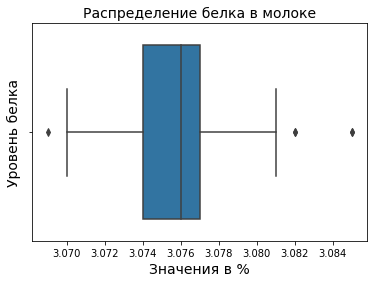

In [31]:
boxplot = sns.boxplot(x=ferma_main['Белок в %'])
boxplot.axes.set_title('Распределение белка в молоке', fontsize=14)
boxplot.set_xlabel('Значения в %', fontsize=14)
boxplot.set_ylabel('Уровень белка', fontsize=14)

Text(0, 0.5, 'Жирность')

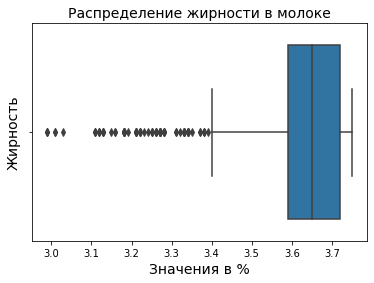

In [32]:
boxplot = sns.boxplot(x=ferma_main['Жирность в %'])
boxplot.axes.set_title('Распределение жирности в молоке', fontsize=14)
boxplot.set_xlabel('Значения в %', fontsize=14)
boxplot.set_ylabel('Жирность', fontsize=14)

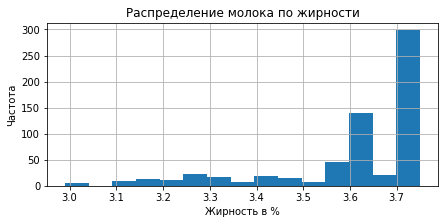

In [33]:
ferma_main['Жирность в %'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 15)
plt.title('Распределение молока по жирности')
plt.xlabel('Жирность в %')
plt.ylabel('Частота')
plt.show()

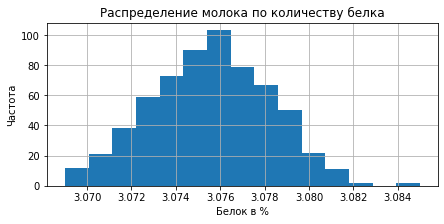

In [34]:
ferma_main['Белок в %'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 15)
plt.title('Распределение молока по количеству белка')
plt.xlabel('Белок в %')
plt.ylabel('Частота')
plt.show()

Больше всего молока производится жирностью 3.75 % с содержанием белка 3.076 %. При этом в норме получать молоко жирностью от 3.6 до 3.7 % и содержанием белка от 3.07 до 3.08 %. В данных видим выбросы: очень редко встречается молоко жирностью меньше 3.4 % и содержанием белка больше 3.08 %.

Далее посмотрим на характеристики корма.

Text(0, 0.5, 'Показатель')

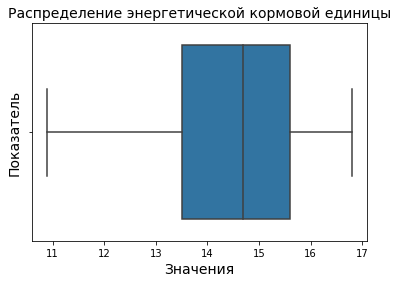

In [35]:
boxplot = sns.boxplot(x=ferma_main['ЭКЕ'])
boxplot.axes.set_title('Распределение энергетической кормовой единицы', fontsize=14)
boxplot.set_xlabel('Значения', fontsize=14)
boxplot.set_ylabel('Показатель', fontsize=14)

Text(0, 0.5, 'Показатель')

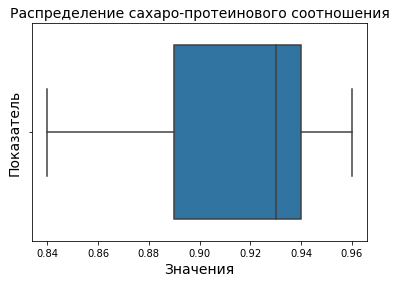

In [36]:
boxplot = sns.boxplot(x= ferma_main['СПО'])
boxplot.axes.set_title('Распределение cахаро-протеинового соотношения', fontsize=14)
boxplot.set_xlabel('Значения', fontsize=14)
boxplot.set_ylabel('Показатель', fontsize=14)

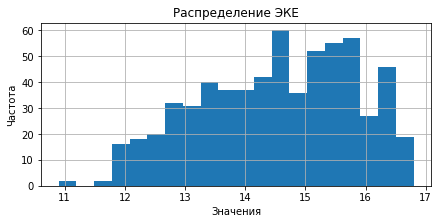

In [37]:
ferma_main['ЭКЕ'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 20)
plt.title('Распределение ЭКЕ')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

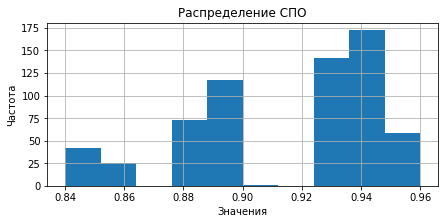

In [38]:
ferma_main['СПО'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 10)
plt.title('Распределение СПО')
plt.xlabel('Значения')
plt.ylabel('Частота')
plt.show()

Норма распределения ЭКЕ - от 13.5 до 15.5 единиц. Значения СПО приближены к 1: от 0.89 до 0.94.

Далее посмотрим на содержание сырого протеина и удой.

Text(0, 0.5, 'Показатели')

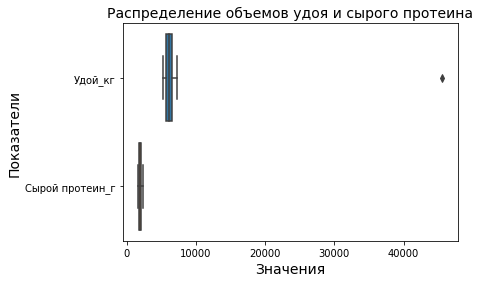

In [39]:
ferma_main_kg = pd.DataFrame(data=ferma_main, columns=['Удой_кг', 'Сырой протеин_г'])
boxplot = sns.boxplot(x='value', y='variable', data=pd.melt(ferma_main_kg))
boxplot.axes.set_title('Распределение объемов удоя и сырого протеина', fontsize=14)
boxplot.set_xlabel('Значения', fontsize=14)
boxplot.set_ylabel('Показатели', fontsize=14)

In [40]:
ferma_main.query('Удой_кг > 40000')

,id,Удой_кг,ЭКЕ,Сырой протеин_г,СПО,Порода,Тип пастбища,Порода папы,Жирность в %,Белок в %,Вкус молока,Возраст
16,17,45616,11.50,1675,0.93,Вис Бик Айдиал,Холмистое,Айдиал,3.22,3.08,вкусно,более_2_лет


В данных обнаружен один выброс, который мы можем удалить без вреда для исследования. Это может быть удой не за год, а за другой промежуток времени, либо случайно была дописана лишняя цифра.

In [41]:
# удалим строку
ferma_main.drop(labels = [16], axis = 0, inplace= True)
ferma_main.reset_index(drop= True, inplace= True)

# проверим результат
ferma_main.query('Удой_кг > 40000')

,id,Удой_кг,ЭКЕ,Сырой протеин_г,СПО,Порода,Тип пастбища,Порода папы,Жирность в %,Белок в %,Вкус молока,Возраст


В датафрейме `ferma_dad` удалим строку с этим же индексом для поддержания соответствия в данных.

In [42]:
# удалим строку
ferma_dad.drop(labels = [16], axis = 0, inplace= True)
ferma_dad.reset_index(drop= True, inplace= True)

# проверим результат
print('Кол-во строк в ferma_main', len(ferma_main))
print('Кол-во строк в ferma_dad', len(ferma_dad))

Кол-во строк в ferma_main 628
Кол-во строк в ferma_dad 628


Text(0, 0.5, 'Показатели')

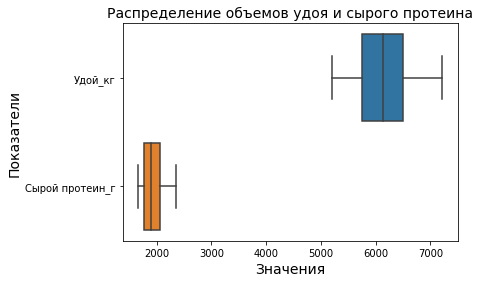

In [43]:
ferma_main_kg = pd.DataFrame(data=ferma_main, columns=['Удой_кг', 'Сырой протеин_г'])
boxplot = sns.boxplot(x='value', y='variable', data=pd.melt(ferma_main_kg))
boxplot.axes.set_title('Распределение объемов удоя и сырого протеина', fontsize=14)
boxplot.set_xlabel('Значения', fontsize=14)
boxplot.set_ylabel('Показатели', fontsize=14)

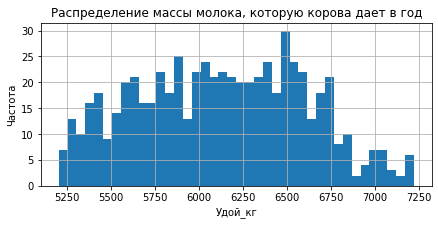

In [44]:
ferma_main['Удой_кг'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 40)
plt.title('Распределение массы молока, которую корова дает в год')
plt.xlabel('Удой_кг')
plt.ylabel('Частота')
plt.show()

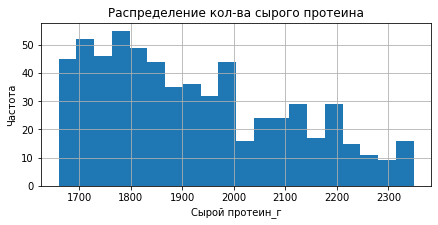

In [45]:
ferma_main['Сырой протеин_г'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 20)
plt.title('Распределение кол-ва сырого протеина')
plt.xlabel('Сырой протеин_г')
plt.ylabel('Частота')
plt.show()

В норме сырого протеина используют от 1700 до 2000 г, а удой получают 5750 - 6500 кг в год. Чаще всего от коров получают 6500 кг молока в год.

#### 3.1.2 В датафрейме ```cow_buy```

Также проверим соотношение жирности и белка

Text(0, 0.5, 'Показатели')

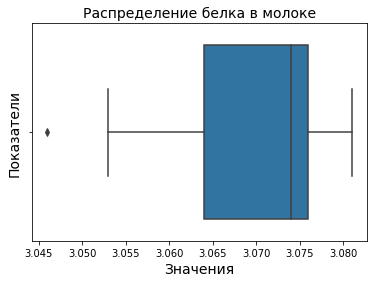

In [46]:
boxplot = sns.boxplot(x=cow_buy['Текущий уровень белка в %'])
boxplot.axes.set_title('Распределение белка в молоке', fontsize=14)
boxplot.set_xlabel('Значения', fontsize=14)
boxplot.set_ylabel('Показатели', fontsize=14)

Text(0, 0.5, 'Показатели')

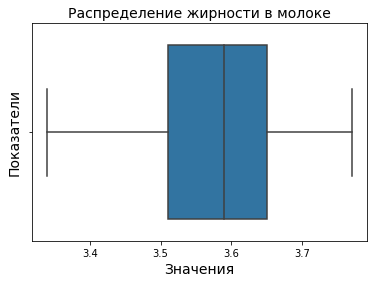

In [47]:
boxplot = sns.boxplot(x=cow_buy['Текущая жирность в %'])
boxplot.axes.set_title('Распределение жирности в молоке', fontsize=14)
boxplot.set_xlabel('Значения', fontsize=14)
boxplot.set_ylabel('Показатели', fontsize=14)

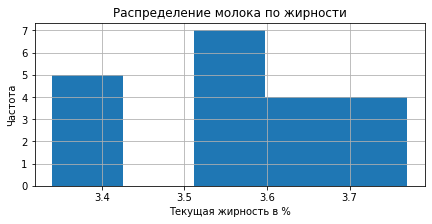

In [48]:
cow_buy['Текущая жирность в %'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 5)
plt.title('Распределение молока по жирности')
plt.xlabel('Текущая жирность в %')
plt.ylabel('Частота')
plt.show()

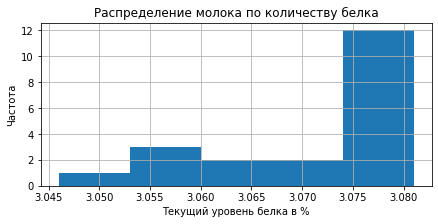

In [49]:
cow_buy['Текущий уровень белка в %'].plot(kind = 'hist', grid=True, figsize = (7,3), bins = 5)
plt.title('Распределение молока по количеству белка')
plt.xlabel('Текущий уровень белка в %')
plt.ylabel('Частота')
plt.show()

В этом датафрейме мы видим в основном значения жирности молока от 3.5 до 3.6 % и уровень белка от 3.075 до 3.08 %.

### 3.2 Проведем статистический анализ категориальных признаков

#### 3.2.1 В датафрейме ```ferma_main```

Посмотрим соотношения каждого признака

In [50]:
# столбец 'Порода'
ferma_main_breed = ferma_main.pivot_table(index= 'Порода', values= 'id', aggfunc= 'count').sort_values(by='id', ascending = True).reset_index()
ferma_main_breed

,Порода,id
0,РефлешнСоверинг,256
1,Вис Бик Айдиал,372


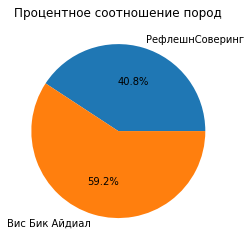

In [51]:
fig, ax = plt.subplots()
ax.pie(ferma_main_breed['id'], labels=ferma_main_breed['Порода'], autopct='%1.1f%%')
plt.title('Процентное соотношение пород')
plt.show()

In [52]:
# столбец 'Тип пастбища'
ferma_main_pasture = ferma_main.pivot_table(index= 'Тип пастбища', values= 'id', aggfunc= 'count').sort_values(by='id', ascending = True).reset_index()
ferma_main_pasture

,Тип пастбища,id
0,Равнинное,278
1,Холмистое,350


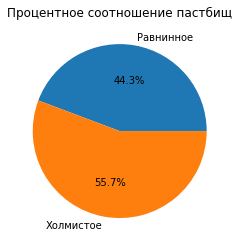

In [53]:
fig, ax = plt.subplots()
ax.pie(ferma_main_pasture['id'], labels=ferma_main_pasture['Тип пастбища'], autopct='%1.1f%%')
plt.title('Процентное соотношение пастбищ')
plt.show()

In [54]:
# столбец 'Порода папы'
ferma_main_dad = ferma_main.pivot_table(index= 'Порода папы', values= 'id', aggfunc= 'count').sort_values(by='id', ascending = True).reset_index()
ferma_main_dad

,Порода папы,id
0,Соверин,311
1,Айдиал,317


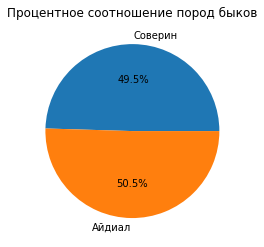

In [55]:
fig, ax = plt.subplots()
ax.pie(ferma_main_dad['id'], labels=ferma_main_dad['Порода папы'], autopct='%1.1f%%')
plt.title('Процентное соотношение пород быков')
plt.show()

In [56]:
# столбец 'Вкус молока'
ferma_main_milk = ferma_main.pivot_table(index= 'Вкус молока', values= 'id', aggfunc= 'count').sort_values(by='id', ascending = True).reset_index()
ferma_main_milk

,Вкус молока,id
0,не вкусно,258
1,вкусно,370


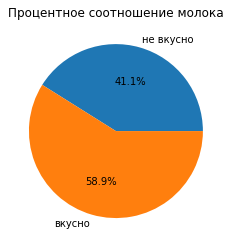

In [57]:
fig, ax = plt.subplots()
ax.pie(ferma_main_milk['id'], labels=ferma_main_milk['Вкус молока'], autopct='%1.1f%%')
plt.title('Процентное соотношение молока')
plt.show()

In [58]:
# столбец 'Возраст'
ferma_main_age = ferma_main.pivot_table(index= 'Возраст', values= 'id', aggfunc= 'count').sort_values(by='id', ascending = True).reset_index()
ferma_main_age

,Возраст,id
0,менее_2_лет,110
1,более_2_лет,518


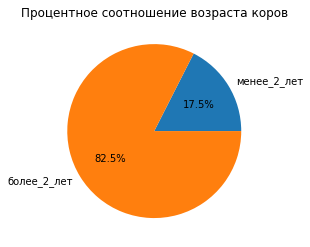

In [59]:
fig, ax = plt.subplots()
ax.pie(ferma_main_age['id'], labels=ferma_main_age['Возраст'], autopct='%1.1f%%')
plt.title('Процентное соотношение возраста коров')
plt.show()

Благодаря построенным диаграммам мы ознакомились с соотношением каждого из признаков. Можно заметить, что несмотря на то, что в основном молоко классифицируется как вкусное, доля невкусного молока значительная - 41.1 %. Также мы видим существенную разницу в соотношении возрастов коров: 82.5 % коров старше 2 лет.

#### 3.2.2 В датафрейме ```cow_buy```

In [60]:
cow_buy.reset_index(inplace= True )

In [61]:
# столбец 'Порода'
cow_buy_breed = cow_buy.pivot_table(index= 'Порода', values= 'index', aggfunc= 'count').sort_values(by='index', ascending = True).reset_index()
cow_buy_breed

,Порода,index
0,Вис Бик Айдиал,9
1,РефлешнСоверинг,11


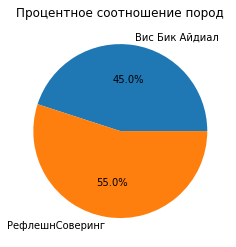

In [62]:
fig, ax = plt.subplots()
ax.pie(cow_buy_breed['index'], labels=cow_buy_breed['Порода'], autopct='%1.1f%%')
plt.title('Процентное соотношение пород')
plt.show()

In [63]:
# столбец 'Тип пастбища'
cow_buy_pasture = cow_buy.pivot_table(index= 'Тип пастбища', values= 'index', aggfunc= 'count').sort_values(by='index', ascending = True).reset_index()
cow_buy_pasture

,Тип пастбища,index
0,Холмистое,9
1,Равнинное,11


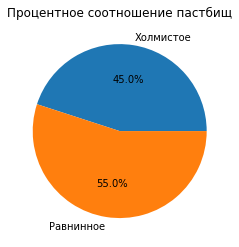

In [64]:
fig, ax = plt.subplots()
ax.pie(cow_buy_breed['index'], labels=cow_buy_pasture['Тип пастбища'], autopct='%1.1f%%')
plt.title('Процентное соотношение пастбищ')
plt.show()

In [65]:
# столбец 'Порода папы'
cow_buy_dad = cow_buy.pivot_table(index= 'Порода папы', values= 'index', aggfunc= 'count').sort_values(by='index', ascending = True).reset_index()
cow_buy_dad

,Порода папы,index
0,Айдиал,8
1,Соверин,12


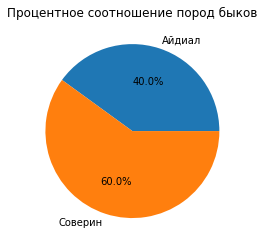

In [66]:
fig, ax = plt.subplots()
ax.pie(cow_buy_dad['index'], labels=cow_buy_dad['Порода папы'], autopct='%1.1f%%')
plt.title('Процентное соотношение пород быков')
plt.show()

In [67]:
# столбец 'Возраст'
cow_buy_age = cow_buy.pivot_table(index= 'Возраст', values= 'index', aggfunc= 'count').sort_values(by='index', ascending = True).reset_index()
cow_buy_age

,Возраст,index
0,менее_2_лет,5
1,более_2_лет,15


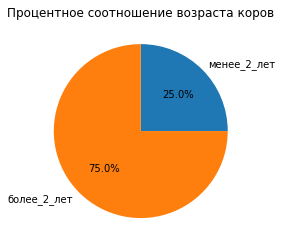

In [68]:
fig, ax = plt.subplots()
ax.pie(cow_buy_age['index'], labels=cow_buy_age['Возраст'], autopct='%1.1f%%')
plt.title('Процентное соотношение возраста коров')
plt.show()

Здесь мы видим также большинство коров (75 %) возраста более 2 лет.

**Вывод:**\
На этом шаге мы подробно изучили данные и заметили следующее:
- Жирность молока в молочном хозяйстве фермера немного больше, чем в "ЭкоФерме": 3.6-3.7 % против 3.5-3.6 %.
- Содержание белка в молоке с обоих хозяйств одинаковое: 3.075-3.08 %.
- В столбце ```'Удой_кг'``` датафрейма ```ferma_main``` был обнаружен и удалён один выброс.
- Из всех количественных признаков нормальное распределение имеет только признак `'Белок в %'` в датафрейме `ferma_main`.
- В молочном хозяйстве фермера доля невкусного молока составляет 41.1 %.
- По возрастному соотношению в обоих хозяйствах большинство коров возраста более 2 лет (82.5 % в молочном хозяйстве фермера и 75 % в "ЭкоФерме").

## 4. Шаг 4. Проведем корреляционный анализ

### 4.1 Изучим взаимосвязь между признаками в датафрейме ```ferma_main```

Так как все количественные параметры за исключением одного имеют ненормальное распределение, мы посчитаем корреляцию Спирмена, чтобы исследовать зависимость между параметрами.

In [69]:
# посчитаем корреляцию
analysis = ferma_main[['Удой_кг','ЭКЕ','Сырой протеин_г','СПО','Жирность в %', 'Белок в %']].reset_index(drop=True)
analysis.corr(method= 'spearman')

,Удой_кг,ЭКЕ,Сырой протеин_г,СПО,Жирность в %,Белок в %
Удой_кг,1.00,0.77,0.44,0.79,0.69,-0.01
ЭКЕ,0.77,1.00,0.38,0.74,0.69,-0.01
Сырой протеин_г,0.44,0.38,1.00,0.49,0.39,0.23
СПО,0.79,0.74,0.49,1.00,0.70,0.11
Жирность в %,0.69,0.69,0.39,0.70,1.00,0.04
Белок в %,-0.01,-0.01,0.23,0.11,0.04,1.00


Text(0.5, 1.0, 'Тепловая карта корреляции')

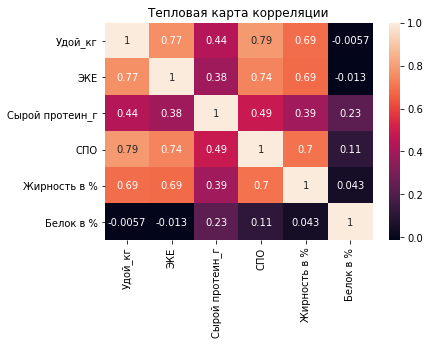

In [70]:
sns.heatmap(analysis.corr(method= 'spearman'), annot=True)
plt.title('Тепловая карта корреляции')

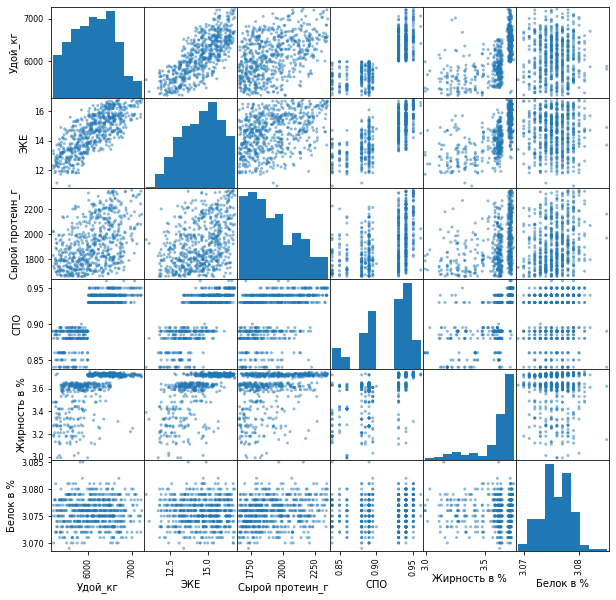

In [71]:
# построим матрицу корреляции
pd.plotting.scatter_matrix(analysis, figsize=(10, 10)) 

plt.show()

Из расчётов видно, что на удой сильнее всего влияют 2 признака: энергетическая кормовая единица (ЭКЕ) и сахаро-протеиновое соотношение (СПО). Также мы можем говорить о наличии мультиколлинеарности, т.к. получили высокую корреляцию между признаками ```ЭКЕ``` и ```СПО```, ```ЭКЕ``` и ```Жирность в %```, ```СПО``` и ```Жирность в %```.

### 4.2 Построим диаграммы рассеяния

#### 4.2.1 Влияние содержания сырого протеина на удой

Text(0.5, 1.0, 'Влияние породы и содержания сырого протеина на удой')

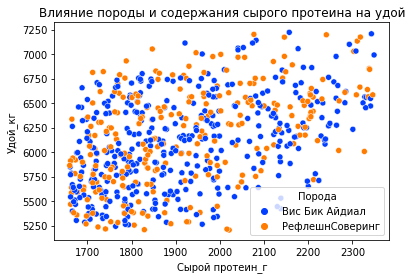

In [72]:
sns.scatterplot(x='Сырой протеин_г', y='Удой_кг', data=ferma_main, palette='bright', hue='Порода')
plt.title('Влияние породы и содержания сырого протеина на удой')

Text(0.5, 1.0, 'Влияние типа пастбища и содержания сырого протеина на удой')

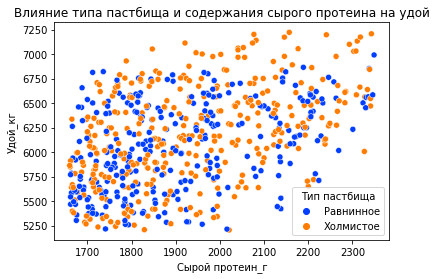

In [73]:
sns.scatterplot(x='Сырой протеин_г', y='Удой_кг', data=ferma_main, palette='bright', hue='Тип пастбища')
plt.title('Влияние типа пастбища и содержания сырого протеина на удой')

Text(0.5, 1.0, 'Влияние породы быка и содержания сырого протеина на удой')

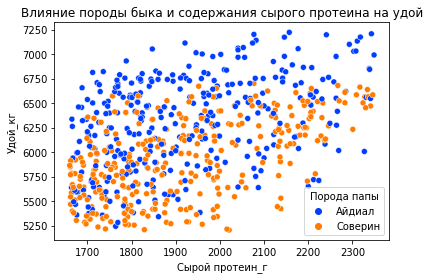

In [74]:
sns.scatterplot(x='Сырой протеин_г', y='Удой_кг', data=ferma_main, palette='bright', hue='Порода папы')
plt.title('Влияние породы быка и содержания сырого протеина на удой')

Text(0.5, 1.0, 'Влияние возраста коровы и содержания сырого протеина на удой')

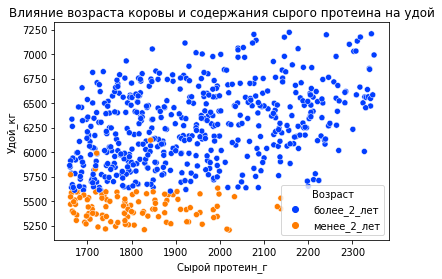

In [75]:
sns.scatterplot(x='Сырой протеин_г', y='Удой_кг', data=ferma_main, palette='bright', hue='Возраст')
plt.title('Влияние возраста коровы и содержания сырого протеина на удой')

Между удоем и содержанием сырого протеина наблюдается линейная зависимость. Нетипичное влияние на эту зависимость оказывает только категориальный признак ```Возраст```: он отчетливо делит уровень удоя от коров старше и моложе 2 лет.

#### 4.2.2 Влияние ЭКЕ на удой <a id ='4.2.2'></a>

Text(0.5, 1.0, 'Влияние породы и ЭКЕ на удой')

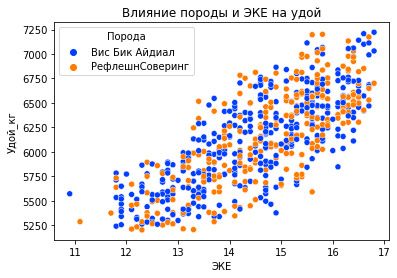

In [76]:
sns.scatterplot(x='ЭКЕ', y='Удой_кг', data=ferma_main, palette='bright', hue='Порода')
plt.title('Влияние породы и ЭКЕ на удой')

Text(0.5, 1.0, 'Влияние типа пастбища и ЭКЕ на удой')

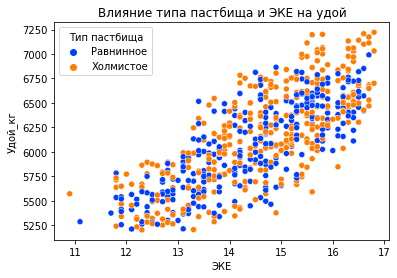

In [77]:
sns.scatterplot(x='ЭКЕ', y='Удой_кг', data=ferma_main, palette='bright', hue='Тип пастбища')
plt.title('Влияние типа пастбища и ЭКЕ на удой')

Text(0.5, 1.0, 'Влияние породы быка и ЭКЕ на удой')

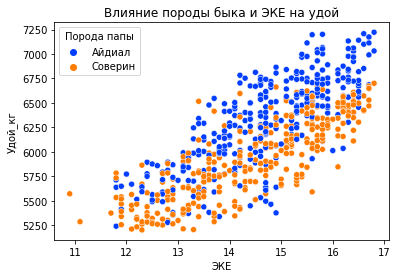

In [78]:
sns.scatterplot(x='ЭКЕ', y='Удой_кг', data=ferma_main, palette='bright', hue='Порода папы')
plt.title('Влияние породы быка и ЭКЕ на удой')

Text(0.5, 1.0, 'Влияние возраста коровы и ЭКЕ на удой')

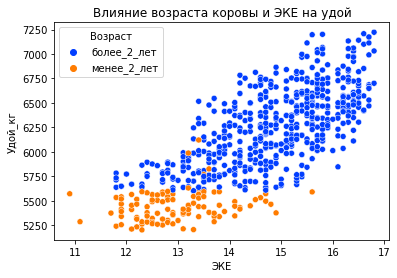

In [79]:
sns.scatterplot(x='ЭКЕ', y='Удой_кг', data=ferma_main, palette='bright', hue='Возраст')
plt.title('Влияние возраста коровы и ЭКЕ на удой')

Между удоем и ЭКЕ зависимость больше похожа на квадратичную, чем на линейную, т.к. расположение точек напоминает широкую параболу. Так же как в случае с содержанием сырого протеина влияние на эту зависимость оказывает категориальный признак ```Возраст```.

#### 4.2.3 Влияние СПО на удой

Text(0.5, 1.0, 'Влияние породы и СПО на удой')

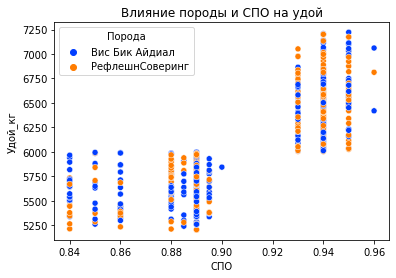

In [80]:
sns.scatterplot(x='СПО', y='Удой_кг', data=ferma_main, palette='bright', hue='Порода')
plt.title('Влияние породы и СПО на удой')

Text(0.5, 1.0, 'Влияние типа пастбища и СПО на удой')

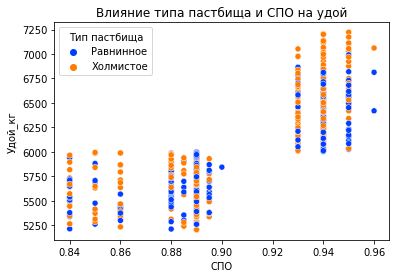

In [81]:
sns.scatterplot(x='СПО', y='Удой_кг', data=ferma_main, palette='bright', hue='Тип пастбища')
plt.title('Влияние типа пастбища и СПО на удой')

Text(0.5, 1.0, 'Влияние породы быка и СПО на удой')

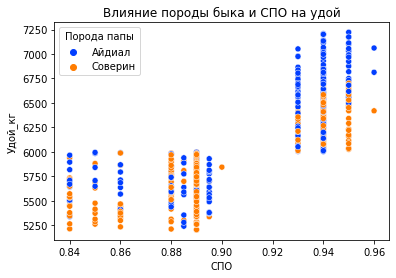

In [82]:
sns.scatterplot(x='СПО', y='Удой_кг', data=ferma_main, palette='bright', hue='Порода папы')
plt.title('Влияние породы быка и СПО на удой')

Text(0.5, 1.0, 'Влияние возраста коровы и СПО на удой')

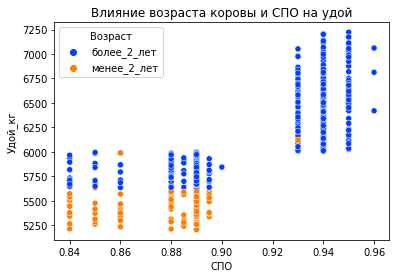

In [83]:
sns.scatterplot(x='СПО', y='Удой_кг', data=ferma_main, palette='bright', hue='Возраст')
plt.title('Влияние возраста коровы и СПО на удой')

Между удоем и СПО зависимость не похожа на линейную, есть чёткое разделение на кластеры.

**Вывод:** Между целевым признаком ```Удой_кг``` и входными признаками наблюдается как линейная, так и нелинейная зависимости. Выявлена зависимость целевого признака ```Удой_кг``` от входного категориального признака ```Возраст```. Также замечена положительная корреляция между признаками ```ЭКЕ``` и ```СПО```, ```ЭКЕ``` и ```Жирность в %```, ```СПО``` и ```Жирность в %```.\
Зависимость целевого признака от входных ```Жирность в %``` и ```Белок в %``` мы рассматривать не стали, т.к. эти два параметра логически не могут влять на удой, в частности, это подтверждается матрицей корреляции.

## 5. Шаг 5. Обучение модели линейной регрессии

### 5.1 Модель № 1

**Отбор признаков.**\
Из списка категориальных признаков мы уберем ```'Вкус молока'```, т.к. этот параметр мы получем на выходе продукта и на наш целевой признак ```'Удой_кг'``` он не оказывает влияния. По той же причине из списка количественных признаков мы уберем ```'Жирность в %'``` и ```'Белок в %'```.

In [84]:
RANDOM_STATE = 42

X = ferma_main.drop(['Удой_кг', 'Вкус молока', 'Жирность в %', 'Белок в %'], axis=1)
y = ferma_main['Удой_кг']

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, random_state= RANDOM_STATE)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст']
num_col_names = ['Сырой протеин_г', 'ЭКЕ', 'СПО']

encoder_1 = OneHotEncoder(drop='first', sparse= False)
X_train_ohe_1 = encoder_1.fit_transform(X_train_1[cat_col_names])
X_test_ohe_1 = encoder_1.transform(X_test_1[cat_col_names])

encoder_col_names_1 = encoder_1.get_feature_names()

scaler_1 = StandardScaler()
X_train_scaled_1 = scaler_1.fit_transform(X_train_1[num_col_names])
X_test_scaled_1 = scaler_1.transform(X_test_1[num_col_names])

X_train_ohe_1 = pd.DataFrame(X_train_ohe_1, columns= encoder_col_names_1)
X_test_ohe_1 = pd.DataFrame(X_test_ohe_1, columns= encoder_col_names_1)
X_train_scaled_1 = pd.DataFrame(X_train_scaled_1, columns= num_col_names)
X_test_scaled_1 = pd.DataFrame(X_test_scaled_1, columns= num_col_names)

X_train_1 = pd.concat([X_train_ohe_1, X_train_scaled_1], axis=1)
X_test_1 = pd.concat([X_test_ohe_1, X_test_scaled_1], axis=1)

model_lr_1 = LinearRegression()
model_lr_1.fit(X_train_1, y_train_1)
predictions_1 = model_lr_1.predict(X_test_1)

residuals_1 = y_test_1 - predictions_1
r2_1 = r2_score(y_test_1, predictions_1)


print('R2:', r2_1)

R2: 0.784407817341697


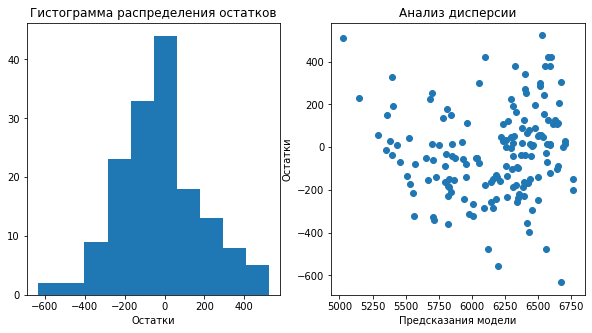

In [85]:
# построим графики

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].hist(bins=10, x= residuals_1)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x= predictions_1, y= residuals_1)
axes[1].set_title('Анализ дисперсии')
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
plt.show()

Распределение остатков немного смещено влево: модель может давать прогнозы, которые больше истинных значений, а на графике дисперсии на двух крайних участках разброс значений больше, чем на среднем. Судя по метрике R2, точность модели - 78.4 %. Можно провести дополнительные исследования и донастроить модель, чтобы улучшить распределение, дисперсию и R2.

### 5.2 Модель № 2

#### 5.2.1 Уберем нелинейность в зависимости признаков ```'Удой_кг'``` и ```'СПО'```

Посмотрим еще раз на распределение признака ```'СПО'```

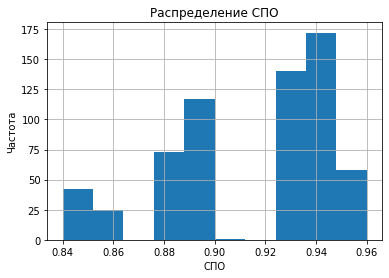

In [86]:
ferma_main['СПО'].plot(kind = 'hist', grid=True)
plt.title('Распределение СПО')
plt.xlabel('СПО')
plt.ylabel('Частота')
plt.show()

Преобразуем этот признак в категориальный бинарный, используя в качестве границы значение 0.92

In [87]:
ferma_main['СПО_OHE'] = (ferma_main['СПО'] < 0.92).astype('int')

# проверим результат
ferma_main

,id,Удой_кг,ЭКЕ,Сырой протеин_г,СПО,Порода,Тип пастбища,Порода папы,Жирность в %,Белок в %,Вкус молока,Возраст,СПО_OHE
0,1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет,1
1,2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.08,вкусно,менее_2_лет,1
2,3,5810,14.00,1854,0.89,РефлешнСоверинг,Холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет,1
3,4,5895,12.40,2012,0.89,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет,1
4,5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.07,вкусно,менее_2_лет,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.40,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.08,не вкусно,более_2_лет,0
624,626,5513,12.90,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.07,вкусно,менее_2_лет,1
625,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет,1
626,628,5746,13.80,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.08,вкусно,более_2_лет,1


#### 5.2.2 Уберем нелинейность в зависимости признаков ```'Удой_кг'``` и ```'ЭКЕ'```

Как мы уже выяснили ранее, между ЭКЕ и удоем наблюдается квадратичная зависимость, поэтому чтобы от нее избавиться, нам нужно ввести новый признак - ЭКЕ в квадрате (`ЭКЕ_2`)

In [88]:
ferma_main['ЭКЕ_2'] = ferma_main['ЭКЕ'] ** 2

# проверим результат
ferma_main

,id,Удой_кг,ЭКЕ,Сырой протеин_г,СПО,Порода,Тип пастбища,Порода папы,Жирность в %,Белок в %,Вкус молока,Возраст,СПО_OHE,ЭКЕ_2
0,1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет,1,201.64
1,2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.08,вкусно,менее_2_лет,1,163.84
2,3,5810,14.00,1854,0.89,РефлешнСоверинг,Холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет,1,196.00
3,4,5895,12.40,2012,0.89,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет,1,153.76
4,5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.07,вкусно,менее_2_лет,1,163.84
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.40,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.08,не вкусно,более_2_лет,0,237.16
624,626,5513,12.90,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.07,вкусно,менее_2_лет,1,166.41
625,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет,1,207.36
626,628,5746,13.80,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.08,вкусно,более_2_лет,1,190.44


#### 5.2.3 Обучим новую модель

In [89]:
RANDOM_STATE = 42

X = ferma_main.drop(['Удой_кг', 'Вкус молока', 'Жирность в %', 'Белок в %', 'ЭКЕ', 'СПО'], axis=1)
y = ferma_main['Удой_кг']

X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X, y, random_state= RANDOM_STATE)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст', 'СПО_OHE']
num_col_names = ['Сырой протеин_г', 'ЭКЕ_2']

encoder_2 = OneHotEncoder(drop='first', sparse= False)
X_train_ohe_2 = encoder_2.fit_transform(X_train_2[cat_col_names])
X_test_ohe_2 = encoder_2.transform(X_test_2[cat_col_names])

encoder_col_names_2 = encoder_2.get_feature_names()

scaler_2 = StandardScaler()
X_train_scaled_2 = scaler_2.fit_transform(X_train_2[num_col_names])
X_test_scaled_2 = scaler_2.transform(X_test_2[num_col_names])

X_train_ohe_2 = pd.DataFrame(X_train_ohe_2, columns= encoder_col_names_2)
X_test_ohe_2 = pd.DataFrame(X_test_ohe_2, columns= encoder_col_names_2)
X_train_scaled_2 = pd.DataFrame(X_train_scaled_2, columns= num_col_names)
X_test_scaled_2 = pd.DataFrame(X_test_scaled_2, columns= num_col_names)

X_train_2 = pd.concat([X_train_ohe_2, X_train_scaled_2], axis=1)
X_test_2 = pd.concat([X_test_ohe_2, X_test_scaled_2], axis=1)

model_lr_2 = LinearRegression()
model_lr_2.fit(X_train_2, y_train_2)
predictions_2 = model_lr_2.predict(X_test_2)

residuals_2 = y_test_2 - predictions_2
r2_2 = r2_score(y_test_2, predictions_2)

print('R2:', r2_2)

R2: 0.8180879926867503


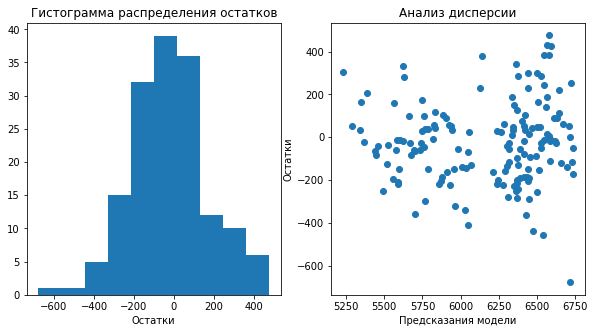

In [90]:
# построим графики

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].hist(bins=10, x= residuals_2)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x= predictions_2, y= residuals_2)
axes[1].set_title('Анализ дисперсии')
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
plt.show()

По сравнению с первой моделью, у второй модели повысилась точность до 81.8 %, распределение всё ещё смещено влево. Дисперсия не улучшилась. Модель можно снова попробовать улучшить.

### 5.3 Модель № 3

Добавим в данные новый признак `'Имя папы'` из датафрейма `ferma_dad`

In [91]:
# посмотрим кол-во строк в датафреймах
print('Кол-во строк в ferma_main:', len(ferma_main))
print('Кол-во строк в ferma_dad:', len(ferma_dad))

Кол-во строк в ferma_main: 628
Кол-во строк в ferma_dad: 628


In [92]:
# добавим столбец
ferma_main = ferma_main.merge(ferma_dad, on= 'id', how= 'left')

# проверим результат
ferma_main

,id,Удой_кг,ЭКЕ,Сырой протеин_г,СПО,Порода,Тип пастбища,Порода папы,Жирность в %,Белок в %,Вкус молока,Возраст,СПО_OHE,ЭКЕ_2,Имя папы
0,1,5863,14.20,1743,0.89,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.08,вкусно,более_2_лет,1,201.64,Буйный
1,2,5529,12.80,2138,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.54,3.08,вкусно,менее_2_лет,1,163.84,Соловчик
2,3,5810,14.00,1854,0.89,РефлешнСоверинг,Холмистое,Соверин,3.59,3.07,не вкусно,более_2_лет,1,196.00,Барин
3,4,5895,12.40,2012,0.89,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.08,не вкусно,более_2_лет,1,153.76,Буйный
4,5,5302,12.80,1675,0.89,Вис Бик Айдиал,Равнинное,Соверин,3.73,3.07,вкусно,менее_2_лет,1,163.84,Барин
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
623,625,6812,15.40,1964,0.94,РефлешнСоверинг,Равнинное,Айдиал,3.74,3.08,не вкусно,более_2_лет,0,237.16,Буйный
624,626,5513,12.90,1700,0.88,РефлешнСоверинг,Равнинное,Соверин,3.64,3.07,вкусно,менее_2_лет,1,166.41,Барин
625,627,5970,14.40,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.08,не вкусно,более_2_лет,1,207.36,Барин
626,628,5746,13.80,1994,0.89,РефлешнСоверинг,Равнинное,Соверин,3.64,3.08,вкусно,более_2_лет,1,190.44,Барин


Обучим третью модель

In [93]:
RANDOM_STATE = 42

X = ferma_main.drop(['Удой_кг', 'Вкус молока', 'Жирность в %', 'Белок в %', 'ЭКЕ', 'СПО'], axis=1)
y = ferma_main['Удой_кг']

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, random_state= RANDOM_STATE)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст', 'СПО_OHE', 'Имя папы']
num_col_names = ['Сырой протеин_г', 'ЭКЕ_2']

encoder_3 = OneHotEncoder(drop='first', sparse= False)
X_train_ohe_3 = encoder_3.fit_transform(X_train_3[cat_col_names])
X_test_ohe_3 = encoder_3.transform(X_test_3[cat_col_names])

encoder_col_names_3 = encoder_3.get_feature_names()

scaler_3 = StandardScaler()
X_train_scaled_3 = scaler_3.fit_transform(X_train_3[num_col_names])
X_test_scaled_3 = scaler_3.transform(X_test_3[num_col_names])

X_train_ohe_3 = pd.DataFrame(X_train_ohe_3, columns= encoder_col_names_3)
X_test_ohe_3 = pd.DataFrame(X_test_ohe_3, columns= encoder_col_names_3)
X_train_scaled_3 = pd.DataFrame(X_train_scaled_3, columns= num_col_names)
X_test_scaled_3 = pd.DataFrame(X_test_scaled_3, columns= num_col_names)

X_train_3 = pd.concat([X_train_ohe_3, X_train_scaled_3], axis=1)
X_test_3 = pd.concat([X_test_ohe_3, X_test_scaled_3], axis=1)

model_lr_3 = LinearRegression()
model_lr_3.fit(X_train_3, y_train_3)
predictions_3 = model_lr_3.predict(X_test_3)

residuals_3 = y_test_3 - predictions_3
r2_3 = r2_score(y_test_3, predictions_3)

print('R2:', r2_3)

R2: 0.8247542745210408


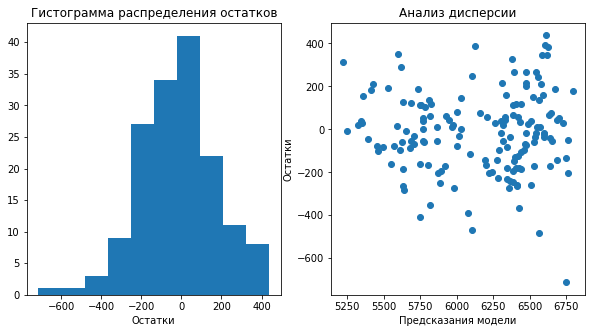

In [94]:
# построим графики

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

axes[0].hist(bins=10, x= residuals_3)
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')

axes[1].scatter(x= predictions_3, y= residuals_3)
axes[1].set_title('Анализ дисперсии')
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
plt.show()

Точность третьей модели увеличилась до 82.5 %, дисперсия немного улучшилась. Распределение остатков тоже немного улучшилось, но ещё наблюдается небольшое смещение влево.

### 5.4 Сравним основные метрики моделей

По метрике МАЕ

In [95]:
mae_1 = mean_absolute_error(y_test_1, predictions_1)
mae_2 = mean_absolute_error(y_test_2, predictions_2)
mae_3 = mean_absolute_error(y_test_3, predictions_3)
print('МАЕ модели № 1:', mae_1)
print('МАЕ модели № 2:', mae_2)
print('МАЕ модели № 3:', mae_3)

МАЕ модели № 1: 164.24194463474916
МАЕ модели № 2: 149.039652223646
МАЕ модели № 3: 146.1630244536231


По метрике MSE

In [96]:
mse_1 = mean_squared_error(y_test_1, predictions_1)
mse_2 = mean_squared_error(y_test_2, predictions_2)
mse_3 = mean_squared_error(y_test_3, predictions_3)
print('MSE модели № 1:', mse_1)
print('MSE модели № 2:', mse_2)
print('MSE модели № 3:', mse_3)

MSE модели № 1: 43887.01500966046
MSE модели № 2: 37030.911311136944
MSE модели № 3: 35673.88988618192


По метрике RMSE

In [97]:
rmse_1 = mean_squared_error(y_test_1, predictions_1, squared= False)
rmse_2 = mean_squared_error(y_test_2, predictions_2, squared= False)
rmse_3 = mean_squared_error(y_test_3, predictions_3, squared= False)
print('RMSE модели № 1:', rmse_1)
print('RMSE модели № 2:', rmse_2)
print('RMSE модели № 3:', rmse_3)

RMSE модели № 1: 209.4922791170607
RMSE модели № 2: 192.43417396901452
RMSE модели № 3: 188.87532895055912


Рассчитаем доверительные интервалы моделей

In [98]:
interval(1, predictions_1)
interval(2, predictions_2)
interval(3, predictions_3)

95% доверительный интервал модели № 1: (6106.009965598841, 6228.04870872839)
95% доверительный интервал модели № 2: (6103.09954488274, 6228.958153299152)
95% доверительный интервал модели № 3: (6092.340075854289, 6221.375070058381)


**Вывод:**\
Исходя из сравнения метрик R2, MAE, MSE и RMSE, а также доверительных интервалов трёх моделей, можно сделать вывод, что модель № 3 наиболее точна, ее предсказания в среднем меньше отличаются от истинных значений, чем у первых двух моделей и доверительный интервал больше. 

### 5.5 Сделаем прогноз на данных из `cow_buy`

Добавим недостающие признаки

In [99]:
cow_buy['ЭКЕ'] = ferma_main['ЭКЕ'].mean() * 1.05
cow_buy['СПО'] = ferma_main['СПО'].mean() * 1.05
cow_buy['Сырой протеин_г'] = ferma_main['Сырой протеин_г'].mean() * 1.05

Подготовим данные

In [100]:
cow_buy['СПО_OHE'] = (cow_buy['СПО'] < 0.92).astype('int')
cow_buy['ЭКЕ_2'] = cow_buy['ЭКЕ'] ** 2

# проверим результат
cow_buy

,index,Порода,Тип пастбища,Порода папы,Имя папы,Текущая жирность в %,Текущий уровень белка в %,Возраст,ЭКЕ,СПО,Сырой протеин_г,СПО_OHE,ЭКЕ_2
0,0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36
1,1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,15.28,0.96,2019.95,0,233.36
2,2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36
3,3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,15.28,0.96,2019.95,0,233.36
4,4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36
5,5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.05,менее_2_лет,15.28,0.96,2019.95,0,233.36
6,6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36
7,7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36
8,8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36
9,9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,15.28,0.96,2019.95,0,233.36


Сделаем предсказания

In [101]:
RANDOM_STATE = 42

X = ferma_main.drop(['Удой_кг', 'Вкус молока', 'Жирность в %', 'Белок в %', 'ЭКЕ', 'СПО'], axis=1)
y = ferma_main['Удой_кг']

X_new = cow_buy.drop(['Текущая жирность в %', 'Текущий уровень белка в %', 'ЭКЕ', 'СПО'], axis=1)

X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X, y, random_state= RANDOM_STATE)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст', 'СПО_OHE', 'Имя папы']
num_col_names = ['Сырой протеин_г', 'ЭКЕ_2']

encoder_3 = OneHotEncoder(drop='first', sparse= False)
X_train_ohe_3 = encoder_3.fit_transform(X_train_3[cat_col_names])
X_test_ohe_3 = encoder_3.transform(X_test_3[cat_col_names])

encoder_col_names_3 = encoder_3.get_feature_names()

scaler_3 = StandardScaler()
X_train_scaled_3 = scaler_3.fit_transform(X_train_3[num_col_names])
X_test_scaled_3 = scaler_3.transform(X_test_3[num_col_names])

X_train_ohe_3 = pd.DataFrame(X_train_ohe_3, columns= encoder_col_names_3)
X_test_ohe_3 = pd.DataFrame(X_test_ohe_3, columns= encoder_col_names_3)
X_train_scaled_3 = pd.DataFrame(X_train_scaled_3, columns= num_col_names)
X_test_scaled_3 = pd.DataFrame(X_test_scaled_3, columns= num_col_names)

X_train_3 = pd.concat([X_train_ohe_3, X_train_scaled_3], axis=1)
X_test_3 = pd.concat([X_test_ohe_3, X_test_scaled_3], axis=1)

model_lr_3 = LinearRegression()
model_lr_3.fit(X_train_3, y_train_3)

X_new_ohe = encoder_3.transform(X_new[cat_col_names])
X_new_scaled = scaler_3.transform(X_new[num_col_names])

X_new_ohe = pd.DataFrame(X_new_ohe, columns= encoder_col_names_3)
X_new_scaled = pd.DataFrame(X_new_scaled, columns= num_col_names)
X_new = pd.concat([X_new_ohe, X_new_scaled], axis=1)

predictions_new = model_lr_3.predict(X_new)

Получим прогноз удоя коров

In [102]:
predictions_new

array([6609.91929681, 6378.71102836, 6283.99977532, 6593.08937654,
       6542.14606633, 6425.38021759, 6609.91929681, 6571.25973712,
       6283.99977532, 6400.54066779, 6344.70785976, 6617.92892634,
       6609.91929681, 6127.4747423 , 6283.99977532, 6593.08937654,
       6344.70785976, 6425.38021759, 6571.25973712, 6542.14606633])

Добавим новые данные в таблицу

In [103]:
cow_buy['Удой_кг'] = predictions_new

# проверим результат
cow_buy

,index,Порода,Тип пастбища,Порода папы,Имя папы,Текущая жирность в %,Текущий уровень белка в %,Возраст,ЭКЕ,СПО,Сырой протеин_г,СПО_OHE,ЭКЕ_2,Удой_кг
0,0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6609.92
1,1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,15.28,0.96,2019.95,0,233.36,6378.71
2,2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36,6284.00
3,3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,15.28,0.96,2019.95,0,233.36,6593.09
4,4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36,6542.15
5,5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.05,менее_2_лет,15.28,0.96,2019.95,0,233.36,6425.38
6,6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6609.92
7,7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6571.26
8,8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36,6284.00
9,9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,15.28,0.96,2019.95,0,233.36,6400.54


## 6. Шаг 6. Обучение модели логистической регрессии

Подготовим данные и обучим модель

In [104]:
RANDOM_STATE = 42

X_cl = ferma_main.drop(['Вкус молока', 'ЭКЕ', 'СПО', 'Удой_кг'], axis=1)
y_cl = ferma_main['Вкус молока']

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, random_state= RANDOM_STATE)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст', 'СПО_OHE', 'Имя папы']
num_col_names = ['Сырой протеин_г', 'ЭКЕ_2', 'Жирность в %', 'Белок в %']

encoder_cl = OneHotEncoder(drop='first', sparse= False)
X_train_ohe_cl = encoder_cl.fit_transform(X_train_cl[cat_col_names])
X_test_ohe_cl = encoder_cl.transform(X_test_cl[cat_col_names])

encoder_col_names_cl = encoder_cl.get_feature_names()

scaler_cl = StandardScaler()
X_train_scaled_cl = scaler_cl.fit_transform(X_train_cl[num_col_names])
X_test_scaled_cl = scaler_cl.transform(X_test_cl[num_col_names])

X_train_ohe_cl = pd.DataFrame(X_train_ohe_cl, columns= encoder_col_names_cl)
X_test_ohe_cl = pd.DataFrame(X_test_ohe_cl, columns= encoder_col_names_cl)
X_train_scaled_cl = pd.DataFrame(X_train_scaled_cl, columns= num_col_names)
X_test_scaled_cl = pd.DataFrame(X_test_scaled_cl, columns= num_col_names)

X_train_cl = pd.concat([X_train_ohe_cl, X_train_scaled_cl], axis=1)
X_test_cl = pd.concat([X_test_ohe_cl, X_test_scaled_cl], axis=1)

y_train_cl = y_train_cl.apply(lambda x: 1 if x == 'вкусно' else 0)
y_test_cl = y_test_cl.apply(lambda x: 1 if x == 'вкусно' else 0)

clf = OneVsRestClassifier(LogisticRegression())
clf = clf.fit(X_train_cl, y_train_cl)
y_cl_pred = clf.predict(X_test_cl)

Построим матрицу ошибок

Text(0.5, 1.0, 'Матрица ошибок')

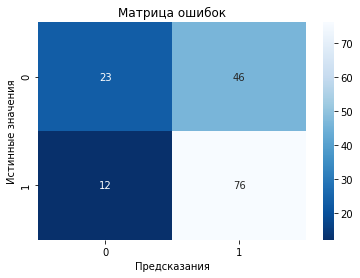

In [105]:
cm = confusion_matrix(y_test_cl, y_cl_pred)
sns.heatmap(cm, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок')

Рассчитаем метрики модели

In [106]:
acc = accuracy_score(y_test_cl, y_cl_pred)
precision = precision_score(y_test_cl, y_cl_pred)
recall = recall_score(y_test_cl, y_cl_pred)
print('Accuracy =', round(acc, 2))
print('Recall =', round(recall, 2))
print('Precision =', round(precision, 2))

Accuracy = 0.63
Recall = 0.86
Precision = 0.62


Модель вычислила верно 86 % коров со вкусным молоком, о чём говорит метрика Recall = 0.86. Но фермеру важно, чтобы молоко всегда было вкусным, то есть нам нужно как можно меньше ложноположительных предсказаний, то есть нужно минимизировать ошибку классификации невкусного молока как вкусного, а значит, надо улучшить метрику Precision.

Поработаем с порогом классификации модели

In [107]:
y_proba = clf.predict_proba(X_test_cl)[:,1]
data = pd.DataFrame(zip(y_test_cl, y_proba), columns= ['y_test_cl', 'y_proba']).sort_values(by= 'y_proba', ascending= False)
data.head()

,y_test_cl,y_proba
85,1,0.86
110,1,0.84
66,1,0.84
51,1,0.84
8,1,0.82


In [108]:
for THRESHOLD in np.arange(0,1,0.1):
    preds = np.where(clf.predict_proba(X_test_cl)[:,1] > THRESHOLD, 1, 0)
    precision_res = precision_score(y_test_cl, preds, zero_division= 1)
    acc_res = accuracy_score(y_test_cl, preds)
    print('Порог', round(THRESHOLD, 1), 'значение Precision:', round(precision_res, 2), 'значение Accuracy:', round(acc_res, 2))

Порог 0.0 значение Precision: 0.56 значение Accuracy: 0.56
Порог 0.1 значение Precision: 0.56 значение Accuracy: 0.56
Порог 0.2 значение Precision: 0.56 значение Accuracy: 0.56
Порог 0.3 значение Precision: 0.56 значение Accuracy: 0.57
Порог 0.4 значение Precision: 0.57 значение Accuracy: 0.57
Порог 0.5 значение Precision: 0.62 значение Accuracy: 0.63
Порог 0.6 значение Precision: 0.72 значение Accuracy: 0.71
Порог 0.7 значение Precision: 0.82 значение Accuracy: 0.62
Порог 0.8 значение Precision: 0.89 значение Accuracy: 0.48
Порог 0.9 значение Precision: 1.0 значение Accuracy: 0.44


Для увеличения Precision мы могли бы выбрать порог 0.8, но тогда сильно падает значение Accuracy. Поэтому, чтобы сохранить точность модели и одновременно улучшить фильтр невкусного молока, мы выберем порог = 0.7

In [109]:
RANDOM_STATE = 42
THRESHOLD = 0.7

X_cl = ferma_main.drop(['Вкус молока', 'ЭКЕ', 'СПО', 'Удой_кг'], axis=1)
y_cl = ferma_main['Вкус молока']

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, random_state= RANDOM_STATE)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст', 'СПО_OHE', 'Имя папы']
num_col_names = ['Сырой протеин_г', 'ЭКЕ_2', 'Жирность в %', 'Белок в %']

encoder_cl = OneHotEncoder(drop='first', sparse= False)
X_train_ohe_cl = encoder_cl.fit_transform(X_train_cl[cat_col_names])
X_test_ohe_cl = encoder_cl.transform(X_test_cl[cat_col_names])

encoder_col_names_cl = encoder_cl.get_feature_names()

scaler_cl = StandardScaler()
X_train_scaled_cl = scaler_cl.fit_transform(X_train_cl[num_col_names])
X_test_scaled_cl = scaler_cl.transform(X_test_cl[num_col_names])

X_train_ohe_cl = pd.DataFrame(X_train_ohe_cl, columns= encoder_col_names_cl)
X_test_ohe_cl = pd.DataFrame(X_test_ohe_cl, columns= encoder_col_names_cl)
X_train_scaled_cl = pd.DataFrame(X_train_scaled_cl, columns= num_col_names)
X_test_scaled_cl = pd.DataFrame(X_test_scaled_cl, columns= num_col_names)

X_train_cl = pd.concat([X_train_ohe_cl, X_train_scaled_cl], axis=1)
X_test_cl = pd.concat([X_test_ohe_cl, X_test_scaled_cl], axis=1)

y_train_cl = y_train_cl.apply(lambda x: 1 if x == 'вкусно' else 0)
y_test_cl = y_test_cl.apply(lambda x: 1 if x == 'вкусно' else 0)

clf = OneVsRestClassifier(LogisticRegression())
clf = clf.fit(X_train_cl, y_train_cl)

preds = np.where(clf.predict_proba(X_test_cl)[:,1] > THRESHOLD, 1, 0)

In [110]:
acc_res = accuracy_score(y_test_cl, preds)
precision_res = precision_score(y_test_cl, preds)
recall_res = recall_score(y_test_cl, preds)
print('Accuracy =', round(acc_res, 2))
print('Recall =', round(recall_res, 2))
print('Precision =', round(precision_res, 2))

Accuracy = 0.62
Recall = 0.42
Precision = 0.82


Посмотрим на матрицу ошибок

Text(0.5, 1.0, 'Матрица ошибок')

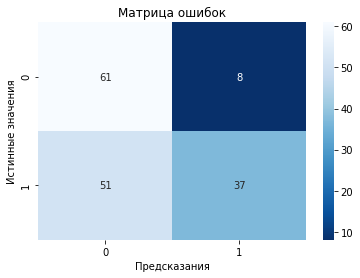

In [111]:
cm_2 = confusion_matrix(y_test_cl, preds)
sns.heatmap(cm_2, annot= True, fmt= 'd', cmap= 'Blues_r')
plt.ylabel('Истинные значения')
plt.xlabel('Предсказания')
plt.title('Матрица ошибок')

Удалось минимизировать ошибки при определении вкусного молока

С помощью обученной модели спрогнозируем вкус молока коров, которых фермер хочет купить.

In [112]:
# для удобства переименуем столбцы
cow_buy.rename(columns = {'Текущая жирность в %':'Жирность в %', 'Текущий уровень белка в %':'Белок в %'}, inplace=True)

# проверим результат
cow_buy.columns

Index(['index', 'Порода', 'Тип пастбища', 'Порода папы', 'Имя папы',
       'Жирность в %', 'Белок в %', 'Возраст', 'ЭКЕ', 'СПО', 'Сырой протеин_г',
       'СПО_OHE', 'ЭКЕ_2', 'Удой_кг'],
      dtype='object')

In [113]:
RANDOM_STATE = 42
THRESHOLD = 0.7

X_cl = ferma_main.drop(['Вкус молока', 'ЭКЕ', 'СПО', 'Удой_кг'], axis=1)
y_cl = ferma_main['Вкус молока']

X_new_cl = cow_buy.drop(['ЭКЕ', 'СПО', 'Удой_кг'], axis=1)

X_train_cl, X_test_cl, y_train_cl, y_test_cl = train_test_split(X_cl, y_cl, random_state= RANDOM_STATE)

cat_col_names = ['Порода', 'Тип пастбища', 'Порода папы', 'Возраст', 'СПО_OHE', 'Имя папы']
num_col_names = ['Сырой протеин_г', 'ЭКЕ_2', 'Жирность в %', 'Белок в %']

encoder_cl = OneHotEncoder(drop='first', sparse= False)
X_train_ohe_cl = encoder_cl.fit_transform(X_train_cl[cat_col_names])
X_test_ohe_cl = encoder_cl.transform(X_test_cl[cat_col_names])

encoder_col_names_cl = encoder_cl.get_feature_names()

scaler_cl = StandardScaler()
X_train_scaled_cl = scaler_cl.fit_transform(X_train_cl[num_col_names])
X_test_scaled_cl = scaler_cl.transform(X_test_cl[num_col_names])

X_train_ohe_cl = pd.DataFrame(X_train_ohe_cl, columns= encoder_col_names_cl)
X_test_ohe_cl = pd.DataFrame(X_test_ohe_cl, columns= encoder_col_names_cl)
X_train_scaled_cl = pd.DataFrame(X_train_scaled_cl, columns= num_col_names)
X_test_scaled_cl = pd.DataFrame(X_test_scaled_cl, columns= num_col_names)

X_train_cl = pd.concat([X_train_ohe_cl, X_train_scaled_cl], axis=1)
X_test_cl = pd.concat([X_test_ohe_cl, X_test_scaled_cl], axis=1)

y_train_cl = y_train_cl.apply(lambda x: 1 if x == 'вкусно' else 0)
y_test_cl = y_test_cl.apply(lambda x: 1 if x == 'вкусно' else 0)

clf = OneVsRestClassifier(LogisticRegression())
clf = clf.fit(X_train_cl, y_train_cl)

X_new_cl_ohe = encoder_cl.transform(X_new_cl[cat_col_names])
X_new_cl_scaled = scaler_cl.transform(X_new_cl[num_col_names])

X_new_cl_ohe = pd.DataFrame(X_new_cl_ohe, columns= encoder_col_names_cl)
X_new_cl_scaled = pd.DataFrame(X_new_cl_scaled, columns= num_col_names)
X_new_cl = pd.concat([X_new_cl_ohe, X_new_cl_scaled], axis=1)

preds = np.where(clf.predict_proba(X_new_cl)[:,1] > THRESHOLD, 1, 0)

Получим прогноз вкуса молока

In [114]:
preds

array([1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [115]:
taste = []
for pred in preds:
    if pred == 1:
        taste.append('вкусно')
    else:
        taste.append('не вкусно')
        
# проверим результат
taste

['вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'вкусно',
 'не вкусно',
 'не вкусно',
 'вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно',
 'не вкусно']

In [116]:
# добавим новый столбец в таблицу
cow_buy['Вкус_молока'] = taste

# проверим результат
cow_buy

,index,Порода,Тип пастбища,Порода папы,Имя папы,Жирность в %,Белок в %,Возраст,ЭКЕ,СПО,Сырой протеин_г,СПО_OHE,ЭКЕ_2,Удой_кг,Вкус_молока
0,0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6609.92,вкусно
1,1,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.54,3.08,менее_2_лет,15.28,0.96,2019.95,0,233.36,6378.71,не вкусно
2,2,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36,6284.00,не вкусно
3,3,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.06,более_2_лет,15.28,0.96,2019.95,0,233.36,6593.09,не вкусно
4,4,РефлешнСоверинг,Равнинное,Айдиал,Буйный,3.64,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36,6542.15,не вкусно
5,5,РефлешнСоверинг,Равнинное,Соверин,Геркулес,3.63,3.05,менее_2_лет,15.28,0.96,2019.95,0,233.36,6425.38,не вкусно
6,6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6609.92,вкусно
7,7,Вис Бик Айдиал,Равнинное,Соверин,Буйный,3.57,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6571.26,не вкусно
8,8,РефлешнСоверинг,Равнинное,Соверин,Барин,3.59,3.07,более_2_лет,15.28,0.96,2019.95,0,233.36,6284.00,не вкусно
9,9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,15.28,0.96,2019.95,0,233.36,6400.54,вкусно


## 7. Шаг 7. Итоговые выводы

Отберём коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко.

In [117]:
selection = cow_buy.query('Удой_кг > 6000 & Вкус_молока == "вкусно"')
selection

,index,Порода,Тип пастбища,Порода папы,Имя папы,Жирность в %,Белок в %,Возраст,ЭКЕ,СПО,Сырой протеин_г,СПО_OHE,ЭКЕ_2,Удой_кг,Вкус_молока
0,0,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6609.92,вкусно
6,6,Вис Бик Айдиал,Холмистое,Айдиал,Геркулес,3.58,3.08,более_2_лет,15.28,0.96,2019.95,0,233.36,6609.92,вкусно
9,9,РефлешнСоверинг,Холмистое,Айдиал,Буйный,3.40,3.08,менее_2_лет,15.28,0.96,2019.95,0,233.36,6400.54,вкусно


Требованиям соответствуют три коровы с уникальными идентификаторами 0, 6 и 9

## Общий вывод

Целью данного исседования была разработка модели машинного обучения, которая поможет молочному хозяйству управлять рисками и принимать объективное решение о покупке животных. 

Первым этапом была выполнена работа по ознакомлению с данными и их предобработке.\
Следующим этапом нами был проведен исследовательский анализ данных.\
Нами были сделаны следующие выводы:
- Жирность молока в молочном хозяйстве фермера немного больше, чем в "ЭкоФерме": 3.6-3.7 % против 3.5-3.6 %.
- Содержание белка в молоке с обоих хозяйств одинаковое.
- В столбце ```'Удой_кг'``` датафрейма ```ferma_main``` был обнаружен и удалён один выброс.
- Из всех количественных признаков нормальное распределение имеет только признак `'Белок в %'` в датафрейме `ferma_main`.
- В молочном хозяйстве фермера доля невкусного молока составляет 41.1 %.
- По возрастному соотношению в обоих хозяйствах большинство коров возраста более 2 лет.

Далее нами был выполнен корреляционный анализ данных.\
В ходе работы мы выяснили, что между целевым признаком ```Удой_кг``` и входными признаками наблюдается как линейная, так и нелинейная зависимости. Выявлена зависимость целевого признака ```Удой_кг``` от входного категориального признака ```Возраст```. Также замечена положительная корреляция между признаками ```ЭКЕ``` и ```СПО```, ```ЭКЕ``` и ```Жирность в %```, ```СПО``` и ```Жирность в %```.

После этого мы перешли к обучению модели линейной регресии для предсказания удоя коров.\
Мы подготовили данные из датафрейма `ferma_main` и обучили три разных модели:
- Для модели № 1 мы исключили такие признаки как: `'Вкус молока'`, т.к. этот параметр мы получем на выходе продукта и на наш целевой признак ```'Удой_кг'``` он не оказывает влияния, а также по той же причине мы исключили `'Жирность в %'` и `'Белок в %'`.
- Для модели № 2 мы убрали нелинейность в зависимости признаков `'Удой_кг'` и `'СПО'` путем преобразования признака `'СПО'` в категориальный бинарный, используя в качестве границы значение 0.92; а также мы убрали нелинейность и в зависимости признаков `'Удой_кг'` и `'ЭКЕ'` путем возведения значений `'ЭКЕ'` в квадрат.
- Для модели № 3 мы добавили в данные новый признак `'Имя папы'` из датафрейма `ferma_dad`.
Три модели мы сравнили по основным метрикам: R2, MAE, MSE, RMSE, построили для каждой модели гистограмму распределения остатков и диаграмму рассеяния для анализа дисперсии, рассчитали доверительный интервал.\
Исходя из сравнения метрик мы сделали вывод, что модель № 3 наиболее точна, ее предсказания в среднем меньше отличаются от истинных значений, чем у первых двух моделей и доверительный интервал больше.\
Выбрав модель № 3 мы сделали предсказания удоя коров на данных датафрейма `cow_buy`. 

Следующей нашей задачей стала задача классификации для предсказания вкусного и не вкусного молока.\
Мы подготовили данные из датафрейма `ferma_main` и обучили модель, после чего построили матрицу корреляции и рассчитали основные метрики модели (Accuracy, Recall, Precision).\
Так как фермеру важно, чтобы молоко всегда было вкусным, мы минимизировали ложноположительные предсказания путем подбора порога классификации и улучшения метрики Precision.\
После настройки модели мы сделали предсказания вкуса молока на данных датафрейма `cow_buy`. 

На заключительном этапе мы отбрали коров, для которых спрогнозирован удой более 6000 килограммов в год и вкусное молоко. Ими оказались три коровы с уникальными идентификаторами 0, 6 и 9.\
Из двадцати предложенных коров это можно считать неплохим результатом. Но если фермер предполагал приобрести больше коров, то, возможно, стоит немного снизить требования ко вкусу молока, так как по удою требованиям соответствуют все предложенные коровы.